In [300]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [301]:
# Зачитываем данные из файлов и, если есть пустые ячейки, то оставить их пустыми, не заполнять Nan

trd = pd.read_csv('train.csv', keep_default_na=False)
tsd = pd.read_csv('test.csv', keep_default_na=False)



'With AGE'

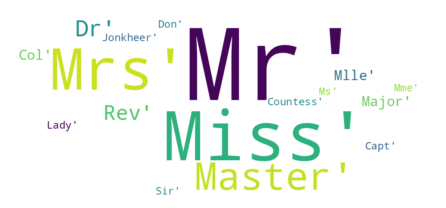

In [302]:
display('With AGE')
trd['Salutation'] = trd.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
trd.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

'NO AGE'

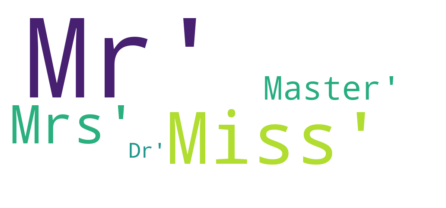

In [303]:
trd_no_age = trd.loc[trd.Age == ""]
trd_with_age = trd.loc[trd.Age != ""]

tsd_no_age = tsd.loc[tsd.Age == ""]
tsd_with_age = tsd.loc[tsd.Age != ""]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_no_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_with_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

display("NO AGE")
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd_no_age.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [304]:
# Преобразуем пол в 0 и 1

trd['Sex'] = LabelEncoder().fit_transform(trd['Sex'])

In [305]:
# Тест

tsd['Sex'] = LabelEncoder().fit_transform(tsd['Sex'])

In [306]:
# Создаем новую таблицу из одной колонки Embarked, содержащей три значения: S, Q, C. 
# Новая таблица будет из трех колонок: Embarked_S, Embarked_Q, Embarked_C, в которых будут только 0 и 1

emb = pd.get_dummies(trd.Embarked, prefix="Embarked", drop_first = False)

# Добавляем новые колонки из новой таблицы в старую таблицу по одному
trd['Embarked_C'] = emb.Embarked_C
trd['Embarked_Q'] = emb.Embarked_Q
trd['Embarked_S'] = emb.Embarked_S

# Теперь нам больше не нужен Embarked
trd.drop("Embarked", axis=1, inplace=True)

In [307]:
# Тест

emb_tsd = pd.get_dummies(tsd.Embarked, prefix="Embarked", drop_first = False)

tsd['Embarked_C'] = emb_tsd.Embarked_C
tsd['Embarked_Q'] = emb_tsd.Embarked_Q
tsd['Embarked_S'] = emb_tsd.Embarked_S

tsd.drop("Embarked", axis=1, inplace=True)

In [308]:
# Тоже самое делаем для классов

pclass = pd.get_dummies(trd.Pclass, prefix="Class", drop_first = False)

trd['Class_1'] = pclass.Class_1
trd['Class_2'] = pclass.Class_2
trd['Class_3'] = pclass.Class_3

# Теперь нам больше не нужен Pclass
trd.drop("Pclass", axis=1, inplace=True)

In [309]:
pclass_tsd = pd.get_dummies(tsd.Pclass, prefix="Class", drop_first = False)

tsd['Class_1'] = pclass_tsd.Class_1
tsd['Class_2'] = pclass_tsd.Class_2
tsd['Class_3'] = pclass_tsd.Class_3

tsd.drop("Pclass", axis=1, inplace=True)

In [310]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Master в имени

master = trd_with_age[trd_with_age['Salutation'] == "Master"]  
display(master.Age.median())

master_age = master.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Master"), ['Age']] = master_age

#display(trd.loc[trd.Salutation == "Master"])


# +++ TSD +++ # 
tsd['Salutation'] = tsd.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
tsd.Salutation.nunique()

tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Master"), ['Age']] = master_age
display(tsd)

3.5

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Salutation
0,892,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,,0,1,0,0,0,1,Mr
1,893,"Wilkes, Mrs. James (Ellen Needs)",0,47,1,0,363272,7,,0,0,1,0,0,1,Mrs
2,894,"Myles, Mr. Thomas Francis",1,62,0,0,240276,9.6875,,0,1,0,0,1,0,Mr
3,895,"Wirz, Mr. Albert",1,27,0,0,315154,8.6625,,0,0,1,0,0,1,Mr
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22,1,1,3101298,12.2875,,0,0,1,0,0,1,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,"Spector, Mr. Woolf",1,,0,0,A.5. 3236,8.05,,0,0,1,0,0,1,Mr
414,1306,"Oliva y Ocana, Dona. Fermina",0,39,0,0,PC 17758,108.9,C105,1,0,0,1,0,0,Dona
415,1307,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.25,,0,0,1,0,0,1,Mr
416,1308,"Ware, Mr. Frederick",1,,0,0,359309,8.05,,0,0,1,0,0,1,Mr


In [311]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Mr в имени
mr = trd_with_age[trd_with_age['Salutation'] == "Mr"]  
display(mr.Age.median())
display(trd.loc[(trd.Age == "") & (trd.Salutation == "Mr")])

mr_age = mr.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Mr"), ['Age']] = mr_age

#display(trd)
#display(trd.loc[trd.Salutation == "Mr"])

30.0

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
5,6,0,"Moran, Mr. James",1,,0,0,330877,8.4583,,Mr,0,1,0,0,0,1
17,18,1,"Williams, Mr. Charles Eugene",1,,0,0,244373,13.0000,,Mr,0,0,1,0,1,0
26,27,0,"Emir, Mr. Farred Chehab",1,,0,0,2631,7.2250,,Mr,1,0,0,0,0,1
29,30,0,"Todoroff, Mr. Lalio",1,,0,0,349216,7.8958,,Mr,0,0,1,0,0,1
36,37,1,"Mamee, Mr. Hanna",1,,0,0,2677,7.2292,,Mr,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,"Marechal, Mr. Pierre",1,,0,0,11774,29.7000,C47,Mr,1,0,0,1,0,0
846,847,0,"Sage, Mr. Douglas Bullen",1,,8,2,CA. 2343,69.5500,,Mr,0,0,1,0,0,1
859,860,0,"Razi, Mr. Raihed",1,,0,0,2629,7.2292,,Mr,1,0,0,0,0,1
868,869,0,"van Melkebeke, Mr. Philemon",1,,0,0,345777,9.5000,,Mr,0,0,1,0,0,1


In [312]:
tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Mr"), ['Age']] = mr_age

In [313]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Miss в имени

miss = trd_with_age[trd_with_age['Salutation'] == "Miss"]  
#display(miss)
display(miss.Age.median())

#display(trd.loc[(trd.Age == "") & (trd.Salutation == "Miss")])

miss_age = miss.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Miss"), ['Age']] = miss_age

#display(trd.loc[trd.Salutation == "Miss"])

21.0

In [314]:
tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Miss"), ['Age']] = miss_age
tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Ms"), ['Age']] = miss_age

In [315]:
mrs = trd_with_age[trd_with_age['Salutation'] == "Mrs"]  
display(mrs.Age.median())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(trd.loc[(trd.Age == "") & (trd.Salutation == "Mrs")])

mrs_age = mrs.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Mrs"), ['Age']] = mrs_age
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#display(trd.loc[trd.Salutation == "Mrs"])

35.0

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
19,20,1,"Masselmani, Mrs. Fatima",0,,0,0,2649,7.2250,,Mrs,1,0,0,0,0,1
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,,1,0,PC 17569,146.5208,B78,Mrs,1,0,0,1,0,0
140,141,0,"Boulos, Mrs. Joseph (Sultana)",0,,0,2,2678,15.2458,,Mrs,1,0,0,0,0,1
166,167,1,"Chibnall, Mrs. (Edith Martha Bowerman)",0,,0,1,113505,55.0000,E33,Mrs,0,0,1,1,0,0
186,187,1,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",0,,1,0,370365,15.5000,,Mrs,0,1,0,0,0,1
256,257,1,"Thorne, Mrs. Gertrude Maybelle",0,,0,0,PC 17585,79.2000,,Mrs,1,0,0,1,0,0
334,335,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",0,,1,0,PC 17611,133.6500,,Mrs,0,0,1,1,0,0
347,348,1,"Davison, Mrs. Thomas Henry (Mary E Finck)",0,,1,0,386525,16.1000,,Mrs,0,0,1,0,0,1
367,368,1,"Moussa, Mrs. (Mantoura Boulos)",0,,0,0,2626,7.2292,,Mrs,1,0,0,0,0,1
375,376,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",0,,1,0,PC 17604,82.1708,,Mrs,1,0,0,1,0,0


In [316]:
tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Mrs"), ['Age']] = mrs_age

In [317]:
doctor = trd_with_age[trd_with_age['Salutation'] == "Dr"]  
display(doctor.Age.median())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(trd.loc[(trd.Age == "") & (trd.Salutation == "Dr")])

doctor_age = doctor.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Dr"), ['Age']] = doctor_age
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(trd.loc[trd.Salutation == "Dr"])

46.5

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
766,767,0,"Brewe, Dr. Arthur Jackson",1,,0,0,112379,39.6,,Dr,1,0,0,1,0,0


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
245,246,0,"Minahan, Dr. William Edward",1,44,2,0,19928,90.0000,C78,Dr,0,1,0,1,0,0
317,318,0,"Moraweck, Dr. Ernest",1,54,0,0,29011,14.0000,,Dr,0,0,1,0,1,0
398,399,0,"Pain, Dr. Alfred",1,23,0,0,244278,10.5000,,Dr,0,0,1,0,1,0
632,633,1,"Stahelin-Maeglin, Dr. Max",1,32,0,0,13214,30.5000,B50,Dr,1,0,0,1,0,0
660,661,1,"Frauenthal, Dr. Henry William",1,50,2,0,PC 17611,133.6500,,Dr,0,0,1,1,0,0
766,767,0,"Brewe, Dr. Arthur Jackson",1,46.5,0,0,112379,39.6000,,Dr,1,0,0,1,0,0
796,797,1,"Leader, Dr. Alice (Farnham)",0,49,0,0,17465,25.9292,D17,Dr,0,0,1,1,0,0


In [318]:
tsd.loc[(tsd.Age == "") & (tsd.Salutation == "Dr"), ['Age']] = doctor_age

In [319]:
tsd.loc[(tsd.Fare == "")] = 7.0


In [320]:
df = trd.copy(deep=True)
# Номер кабины нужен?
df.drop("Cabin", axis=1, inplace=True)
# Номер билета?
df.drop("Ticket", axis=1, inplace=True)
df.drop("Name", axis=1, inplace=True)
df.drop("Salutation", axis=1, inplace=True)
df.drop("PassengerId", axis=1, inplace=True)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#display (df)

cols = df.columns.tolist()
print(cols[1:])   

cols = cols[1:] + [cols[0]]

df = df[cols]
print(cols)   

display (df)

lable = [trd.Survived]

['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Class_1', 'Class_2', 'Class_3']
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Class_1', 'Class_2', 'Class_3', 'Survived']


,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Survived
0,1,22,1,0,7.2500,0,0,1,0,0,1,0
1,0,38,1,0,71.2833,1,0,0,1,0,0,1
2,0,26,0,0,7.9250,0,0,1,0,0,1,1
3,0,35,1,0,53.1000,0,0,1,1,0,0,1
4,1,35,0,0,8.0500,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,27,0,0,13.0000,0,0,1,0,1,0,0
887,0,19,0,0,30.0000,0,0,1,1,0,0,1
888,0,21,1,2,23.4500,0,0,1,0,0,1,0
889,1,26,0,0,30.0000,1,0,0,1,0,0,1


In [321]:
tsd_df = tsd.copy(deep = True)
# Номер кабины нужен?
tsd_df.drop("Cabin", axis=1, inplace=True)
# Номер билета?
tsd_df.drop("Ticket", axis=1, inplace=True)
tsd_df.drop("Name", axis=1, inplace=True)
tsd_df.drop("Salutation", axis=1, inplace=True)
tsd_df.drop("PassengerId", axis=1, inplace=True)

#tsd_cols = tsd_df.columns.tolist()
#print(tsd_cols)   

#tsd_cols = tsd_cols[1:] + [tsd_cols[0]]

#tsd_df = tsd_df[tsd_cols]
#print(tsd_cols)   

#display (tsd_df)


In [322]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf

In [323]:
# Модуль отображения потерь лежит тут !
#https://github.com/stared/livelossplot 
# график потерь 
from livelossplot import PlotLossesKeras

In [324]:
# 12 фич

lable = df['Survived']
df.drop("Survived", axis=1, inplace=True)

#print(lable)
#print(df)

df['Age'] = pd.to_numeric(df['Age'])


data = df.to_numpy()
display (data)

array([[ 1., 22.,  1., ...,  0.,  0.,  1.],
       [ 0., 38.,  1., ...,  1.,  0.,  0.],
       [ 0., 26.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 0., 21.,  1., ...,  0.,  0.,  1.],
       [ 1., 26.,  0., ...,  1.,  0.,  0.],
       [ 1., 32.,  0., ...,  0.,  0.,  1.]])

In [336]:
tsd_df['Age'] = pd.to_numeric(tsd_df['Age'])
tsd_df['Fare'] = pd.to_numeric(tsd_df['Fare'])

#display(tsd_df)

tsd_data = tsd_df.to_numpy()
display(tsd_data)


array([[ 1. , 34.5,  0. , ...,  0. ,  0. ,  1. ],
       [ 0. , 47. ,  1. , ...,  0. ,  0. ,  1. ],
       [ 1. , 62. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [ 1. , 38.5,  0. , ...,  0. ,  0. ,  1. ],
       [ 1. , 30. ,  0. , ...,  0. ,  0. ,  1. ],
       [ 1. ,  3.5,  1. , ...,  0. ,  0. ,  1. ]])

In [ ]:
model_2 = Sequential()

model_2.add(Dense(11, input_dim=11, activation='relu'))
model_2.add(Dense(4, activation='relu'))

#выходной слой
model_2.add(Dense(1, activation='sigmoid'))


model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.fit(data, lable,           
          callbacks=[PlotLossesKeras()],
          epochs=120, 
          batch_size=10,  
          verbose=2)

In [ ]:
print(model_2.predict([[1, 34.5, 0,0,7.8292,0,1,0,0,0,1]]))

print(model_2.predict([[1, 19, 0,0,7.8292,0,1,0,0,0,1]]))

print(model_2.predict([[1, 44, 0,0,7.8292,0,1,0,0,0,1]]))
# погиб

In [ ]:
#             Embarked_C  Embarked_Q  Embarked_S                                
print(model_2.predict([[0, 35, 0,0,31.6833,0,0,1,1,0,0]]))
print(model_2.predict([[0, 35, 0,0,31.6833,1,0,0,1,0,0]]))
print(model_2.predict([[0, 35, 0,0,31.6833,0,1,0,1,0,0]]))

# выжила

In [ ]:
print(model_2.predict([[0, 35, 1,2,23.45,0,0,1,0,0,1]]))

# погибла

In [ ]:
print(model_2.predict([[0, 18, 0,0,7.2292,1,0,0,0,0,1]]))

# выжила

In [ ]:
print(model_2.predict([[1, 25, 0,0,7.65,0,0,1,0,0,1]]))

#выжил

In [ ]:
predictons = model_2.predict()